# Clustering Anomaly Detection Exercises
---

### Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import env

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

In [6]:
# function to get curriculum data
def get_curriculum_logs():
    if os.path.isfile("curriculum_logs.csv"):
        return pd.read_csv("curriculum_logs.csv", index_col=False)
    else:
        # read sql query into dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        sql = '''
        SELECT date, time, path, ip, user_id, name, program_id, start_date, end_date
        FROM logs
        JOIN cohorts ON logs.cohort_id = cohorts.id;
        '''
        df = pd.read_sql(sql, url)

        # dataframe to csv
        df.to_csv("curriculum_logs.csv", index = False)

        return df
# get data    
logs = get_curriculum_logs()
logs.head()

,date,time,path,ip,user_id,name,program_id,start_date,end_date
0,2018-01-26,09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
1,2018-01-26,09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
3,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
4,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [7]:
# change index to datetime using date and time columns 
logs = logs.set_index(pd.to_datetime(logs.date + ' ' + logs.time)).drop(columns=['date', 'time'])
logs.head()

,path,ip,user_id,name,program_id,start_date,end_date
2018-01-26 09:55:03,/,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:02,java-ii,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:06,slides/object_oriented_programming,97.105.19.61,1,Hampton,1,2015-09-22,2016-02-06
2018-01-26 09:56:24,javascript-i/conditionals,97.105.19.61,2,Teddy,2,2018-01-08,2018-05-17


In [9]:
# get total page views and n_unique pages viewed
pages = logs.groupby(['user_id'])['path'].agg(['count', 'nunique'])
pages

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [11]:
# create min-max scaler
scaler = MinMaxScaler().fit(pages)
# transform
pages_scaled_array = scaler.transform(pages)
# preview
pages_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

In [12]:
# create dbscan object
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(pages_scaled_array)
print(dbsc)

DBSCAN(eps=0.1, min_samples=4)


In [13]:
# add scaled values onto dataframe
pages_scaled_df = pd.DataFrame(pages_scaled_array, columns=['count_scaled', 'nunique_scaled'], index=pages.index)
pages_scaled_df

,count_scaled,nunique_scaled
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026
...,...,...
977,0.004745,0.011282
978,0.003015,0.017436
979,0.007034,0.019487


In [15]:
# merge scaled and unscaled dataframes
pages = pages.merge(pages_scaled_df, left_index=True, right_index=True)
pages

,count,nunique,count_scaled,nunique_scaled
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [18]:
# get array of dbscan labels
labels = dbsc.labels_
labels[0:10]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [19]:
# add labels to dataframe
pages['labels'] = labels
# view clusters created by dbscan
pages.labels.value_counts()

 0    906
-1      5
Name: labels, dtype: int64

In [21]:
# isolate potential anomalies
pages[pages.labels == -1]

,count,nunique,count_scaled,nunique_scaled,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16322,436,0.911177,0.446154,-1
248,5075,625,0.283274,0.640000,-1


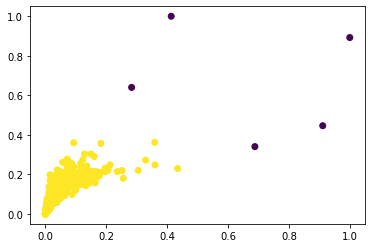

In [22]:
# plot data
plt.scatter(pages['count_scaled'], pages['nunique_scaled'], c=pages.labels)
plt.show();